### Importing Datas

In [10]:
from kmer_counting import rna_strand_list_to_matrix, sequence2matrix
import numpy as np 
import pandas as pd
from Bio import SeqIO
import os

In [11]:
circ_rna_path = "dataset/circRNA_fasta"
circ_rna_seq = [str(i.seq) for i in list(SeqIO.parse(circ_rna_path, "fasta"))]
non_circ_rna_path = "dataset/noncircRNA.fa"
non_circ_rna_path = [str(i.seq) for i in list(SeqIO.parse(non_circ_rna_path, "fasta"))]
len(circ_rna_seq), len(non_circ_rna_path)

(32914, 47589)

In [12]:
def convert_to_vector(list_seq, file_path):
    converter = sequence2matrix()
    seq = [i["sequence"] for i in list_seq]
    matrix = converter.fit(seq, save_dir=file_path)
    for i,j in zip(matrix,list_seq):
        j["vector"] = i
    return list_seq

In [13]:
all_data = [{"sequence":i,
             "label":"circ_rna"} for i in circ_rna_seq]
[all_data.append({"sequence":i,"label":"non_circ_rna"}) for i in non_circ_rna_path]
len(all_data)

80503

In [14]:
matrix = convert_to_vector(all_data, "dataset/data")
np.save("dataset/all_data", matrix)

### Preprocessing Data

In [15]:
import math
from typing import List
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from multiprocessing import Pool
import multiprocessing

In [16]:
# load data
X = np.array([[*i["vector"].values()] for i in np.load("dataset/all_data.npy", allow_pickle=True) if i["vector"] != 0])
X = X.astype("float64")
X.dtype, X.shape

(dtype('float64'), (80303, 256))

In [17]:
def gauss(x:float, sigma:float):
    #print(math.exp(-0.5*x*x/(sigma*sigma))/(sigma*math.sqrt(2*math.pi)))
    return math.exp(-0.5*x*x/(sigma*sigma))/(sigma*math.sqrt(2*math.pi))

In [18]:
def gaussian_blur(vector:List[str], kernel_size:int=5,sigma:float=1):
    vector_length = len(vector)
    kernel_size = int(0.1*vector_length)
    new_vector = copy.deepcopy(vector)
    for i in range(vector_length):
        new_value = 0
        for j in range(max(0, i-kernel_size), min(vector_length,i+kernel_size)):
            new_value += gauss(j-i, sigma)*new_vector[j]
        new_vector[i] = new_value/(min(vector_length,i+vector_length)-max(0, i-vector_length))
    return new_vector

In [19]:
np.save("dataset/processed_data", [gaussian_blur(vector) for vector in tqdm.tqdm(X)])

  0%|          | 21/80303 [00:00<06:39, 200.92it/s]

100%|██████████| 80303/80303 [06:07<00:00, 218.74it/s]


### Data Load Splitting

In [27]:
X = np.load("dataset/processed_data.npy")
converter = {
    "circ_rna": 0,
    "non_circ_rna":1
}
y = [converter[i["label"]] for i in np.load("dataset/all_data.npy", allow_pickle=True) if i["vector"] != 0]

In [32]:
from sklearn.model_selection import train_test_split
# for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 
# for classification
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 22973, 1: 33239}

### Model Training

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

In [34]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print("using", device)
torch.backends.cudnn.benchmark = True

using cuda:0


In [35]:
tensor_x_train = torch.tensor(X_train).to(device)
tensor_y_train = torch.tensor(y_train).to(device)
tensor_x_test = torch.tensor(X_test).to(device)
tensor_y_test = torch.tensor(y_test).to(device)

(tensor_x_train.shape, tensor_y_train.shape), (tensor_x_test.shape, tensor_y_test.shape)

((torch.Size([56212, 256]), torch.Size([56212])),
 (torch.Size([24091, 256]), torch.Size([24091])))

In [46]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim

        #Defining the layers
        self.layer1 = nn.Linear(input_size, hidden_dim, bias=True)
        self.activationlayer1 = nn.LeakyReLU()
        self.layer2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.activationlayer2 = nn.LeakyReLU()
        self.layer3 = nn.Linear(hidden_dim, int(hidden_dim/2), bias=True)
        self.activationlayer3 = nn.LeakyReLU()
        self.layer4 = nn.Linear(int(hidden_dim/2), int(hidden_dim/4), bias=True)
        self.activationlayer4 = nn.LeakyReLU()
        self.ouput = nn.Linear(int(hidden_dim/4), output_size, bias=True)
        # for classification
        self.outputactivation = nn.Sigmoid()
        # for predicition
        #self.outputactivation = nn.Hardtanh(min_val=min_val, max_val=max_val)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.activationlayer1(x)
        x = self.layer2(x)
        x = self.activationlayer2(x)
        x = self.layer3(x)
        x = self.activationlayer3(x)
        x = self.layer4(x)
        x = self.activationlayer4(x)
        x = self.ouput(x)
        x = self.outputactivation(x)
        return x

In [47]:
input_size = tensor_x_train.shape[1]
hidden_dim = 256
batch_size = 64
learning_rate = 1e-5
output_size = 1
input_size

256

In [48]:
import torch.utils.data as data
from torcheval.metrics import BinaryAccuracy


# compile model
model = Model(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loader = data.DataLoader(data.TensorDataset(tensor_x_train, tensor_y_train), shuffle=True, batch_size=batch_size)
validation_loader = data.DataLoader(data.TensorDataset(tensor_x_test, tensor_y_test), shuffle=True, batch_size=batch_size)
#scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# this is for classification
loss_fn = nn.BCELoss().to(device) # sparse categorical cross entropy
metric = BinaryAccuracy().to(device)


In [49]:
from torchinfo import summary

summary(model, input_size=(batch_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 1]                   --
├─Linear: 1-1                            [64, 256]                 65,792
├─LeakyReLU: 1-2                         [64, 256]                 --
├─Linear: 1-3                            [64, 256]                 65,792
├─LeakyReLU: 1-4                         [64, 256]                 --
├─Linear: 1-5                            [64, 128]                 32,896
├─LeakyReLU: 1-6                         [64, 128]                 --
├─Linear: 1-7                            [64, 64]                  8,256
├─LeakyReLU: 1-8                         [64, 64]                  --
├─Linear: 1-9                            [64, 1]                   65
├─Sigmoid: 1-10                          [64, 1]                   --
Total params: 172,801
Trainable params: 172,801
Non-trainable params: 0
Total mult-adds (M): 11.06
Input size (MB): 0.07
Forward/backward pa

In [50]:
def train_one_epoch():
    step_loss = 0
    step_acc = 0
    running_loss = 0
    running_acc = 0
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Make predictions for this batch
        outputs = model(inputs.cuda().float()).squeeze()

        # for classification: convert labels to long tensor
        labels = labels.cuda().float()
        
        # for predicition: convert labels to float tensor
        #labels = torch.reshape(labels.cuda().float(), (-1,1))
        
        # Compute the loss and its gradients
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Compute the accuracy
        metric.update(outputs, labels)
        
        # Adjust learning weights
        optimizer.step()
        #scheduler.step()
        
        # Gather data loss and accuracy
        running_loss += loss.item()
        running_acc += metric.compute().item()
    
    step_loss = (running_loss/len(training_loader))
    step_acc = (running_acc/len(training_loader))
        # print('  STEP {} loss: {}, accuracy: {}'.format(steps+1, running_loss/len(training_loader), running_acc/len(training_loader)))
    return step_loss, step_acc

In [51]:
class history:
    def __init__(self):
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        self.times = []
    def add_history(self, train_loss, train_acc, val_loss, val_acc, time_spent):
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)
        self.times.append(time_spent)

In [52]:
h = history()
best_vloss = 1_000_000.
best_vacc = 0

In [55]:
import time

epoch_number = 0
EPOCHS = 50
model_name = "torchmodel_v0.0.0"
torch.backends.cudnn.benchmark = True

for epoch in range(EPOCHS):
    start_time = time.time()
    print('EPOCH {}/{}:'.format(epoch_number + 1, EPOCHS))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    avg_loss, avg_acc = train_one_epoch()


    running_vloss = 0.0
    runing_acc = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            
            # for classification
            vlabels = vlabels.cuda().float()
            
            # for predicition
            #vlabels = torch.reshape(vlabels.cuda().float(), (-1,1))
            
            voutputs = model(vinputs.cuda().float()).squeeze()
            metric.update(voutputs, vlabels)
            runing_acc += metric.compute().item()
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / len(validation_loader)
    avg_vacc = runing_acc / len(validation_loader)
    print('loss: {}, acc: {}, val_loss: {}, val_acc: {}, time:{}'.format(avg_loss, avg_acc, avg_vloss, avg_vacc, (time.time() - start_time)))
    
    # add history 
    h.add_history(avg_loss, avg_acc, avg_vloss, avg_vacc, (time.time() - start_time))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/{}.{}.loss'.format(model_name, epoch_number)
        torch.save(model.state_dict(), model_path)
        print("saved")
    elif avg_vacc > best_vacc:
        best_vacc = avg_vacc
        model_path = 'models/{}.{}.acc'.format(model_name,epoch_number)
        torch.save(model.state_dict(), model_path)
        print("saved")
    epoch_number += 1

EPOCH 1/50:
loss: 0.03783340512301277, acc: 0.8959179086625508, val_loss: 0.03379184380173683, val_acc: 0.9054821386577596, time:3.0495102405548096
saved
EPOCH 2/50:
loss: 0.03310128001589434, acc: 0.913116813858757, val_loss: 0.030513811856508255, val_acc: 0.9197167147059656, time:2.489819288253784
saved
EPOCH 3/50:
loss: 0.030231738207433734, acc: 0.9251858109228983, val_loss: 0.02809932827949524, val_acc: 0.9299861970567577, time:2.305208206176758
saved
EPOCH 4/50:
loss: 0.028146513704098212, acc: 0.9341040615742524, val_loss: 0.026496950536966324, val_acc: 0.9377875236364511, time:2.791146993637085
saved
EPOCH 5/50:
loss: 0.026530222767811435, acc: 0.9409955904752321, val_loss: 0.025465434417128563, val_acc: 0.9439007518146019, time:2.639949083328247
saved
EPOCH 6/50:
loss: 0.025201813653969674, acc: 0.9464752770392425, val_loss: 0.024337396025657654, val_acc: 0.9488431091966301, time:2.342369794845581
saved
EPOCH 7/50:
loss: 0.024050964038836026, acc: 0.9509510610833238, val_loss:

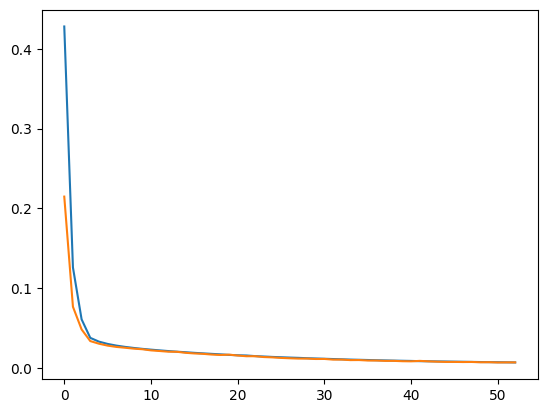

In [59]:
import matplotlib.pyplot as plt

plt.plot(h.train_loss)
plt.plot(list(i.item() for i in h.val_loss))
plt.savefig("result/loss_plot.png")

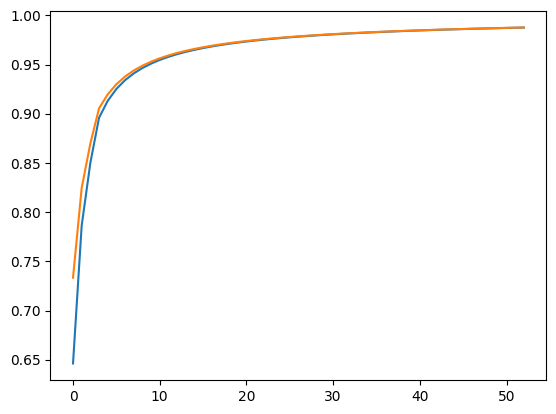

In [60]:
plt.plot(h.train_acc)
plt.plot( h.val_acc)
plt.savefig("result/accuracy_plot.png")

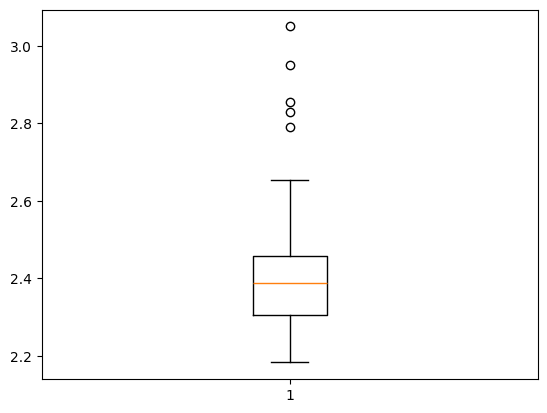

In [61]:
plt.boxplot(h.times)
plt.savefig("result/time_spent_per_epoch.png")